In [1]:
%matplotlib inline
from pylab import *
import cv2

from os import listdir
from tqdm import tqdm

from parse import search

from pathlib import Path

import torch
torch.cuda.empty_cache()

from utils import cuda

from generate_masks import get_model
from dataset import load_image

from albumentations import Compose, Normalize
from albumentations.torch.functional import img_to_tensor

In [2]:
rcParams['figure.figsize'] = 10, 10

In [3]:
def img_transform(p=1):
    return Compose([
        Normalize(p=1)
    ], p=p)

def mask_overlay(image, mask, color=(0, 255, 0)):
    """
    Helper function to visualize mask on the top of the car
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(np.uint8)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0    
    img[ind] = weighted_sum[ind]    
    return img

In [4]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img)
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

In [5]:
model_path = 'runs/debug/model.pt'
model = get_model(model_path, model_type='AlbuNet')

In [6]:
data_path = Path('/home/raznem/proj_kaggle_airbus/data/test_v2')

In [7]:
out_pred_rows = []

for file_name in tqdm(list(data_path.glob('*'))):

    c_img_name = search('test_v2/{}.jpg', str(file_name))[0]
        
    image = load_image(file_name)

    with torch.no_grad():
        input_image = torch.unsqueeze(img_to_tensor(img_transform(p=1)(image=image)['image']).cuda(), dim=0)

    mask = model(input_image)
    mask_array = mask.data[0].cpu().numpy()[0]

    cur_rles = multi_rle_encode(mask_array > 0)
    
    if len(cur_rles)>0:
        for c_rle in cur_rles:
            out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': c_rle}]
    else:
        out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': None}]

  0%|          | 0/15606 [00:00<?, ?it/s]/home/agaidash/anastasiia/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
100%|██████████| 15606/15606 [28:15<00:00,  9.21it/s]


In [21]:
import pandas as pd

# submission_df = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)
submission_df.sample(3)

,ImageId,EncodedPixels
13229,9763a5a22.jpg,None
9447,9a1e626ab.jpg,380483 6 381249 11 382014 15 382779 19 383545 ...
8839,d991a1df2.jpg,None


In [ ]:
image = load_image('/home/raznem/proj_kaggle_airbus/data/test_v2/efc2d1f3e.jpg')
mask = rle_decode('514127 7 514893 12 515660 14 516427 15 517194 17 517962 17 518730 18 519498 18 520266 18 521034 19 521802 19 522570 19 523338 19 524105 20 524873 21 525640 22 526407 23 527175 23 527942 24 528709 25 529477 26 530245 26 531012 27 531780 27 532547 28 533315 28 534082 29 534850 29 535618 29 536386 28 537154 28 537922 28 538690 28 539458 28 540226 28 540994 28 541762 28 542531 27 543299 27 544067 27 544835 27 545603 27 546371 27 547139 27 547907 27 548675 27 549442 28 550210 28 550978 28 551746 28 552514 28 553281 29 554049 29 554817 29 555585 29 556353 29 557121 29 557889 29 558657 29 559425 28 560193 28 560961 28 561729 28 562496 29 563264 30 564032 30 564800 30 565568 30 566336 30 567104 30 567872 30 568640 29 569408 29 570176 29 570944 29 571712 29 572480 29 573248 28 574016 28 574784 28 575552 28 576320 28 577088 28 577856 28 578624 28 579391 29 580159 29 580927 29 581695 29 582463 29 583231 29 583998 30 584766 30 585534 30 586303 29 587071 29 587839 29 588607 29 589375 29')

In [ ]:
imshow(mask_overlay(image, mask))

In [50]:
filenames = [
    '9c3b58a7d',
    '60226facb',
    '69d71b96d',
    '50b9285e6',
    '6b1141818',
    'f11ba532c',
    '8e39008ae',
    'efecac935',
]

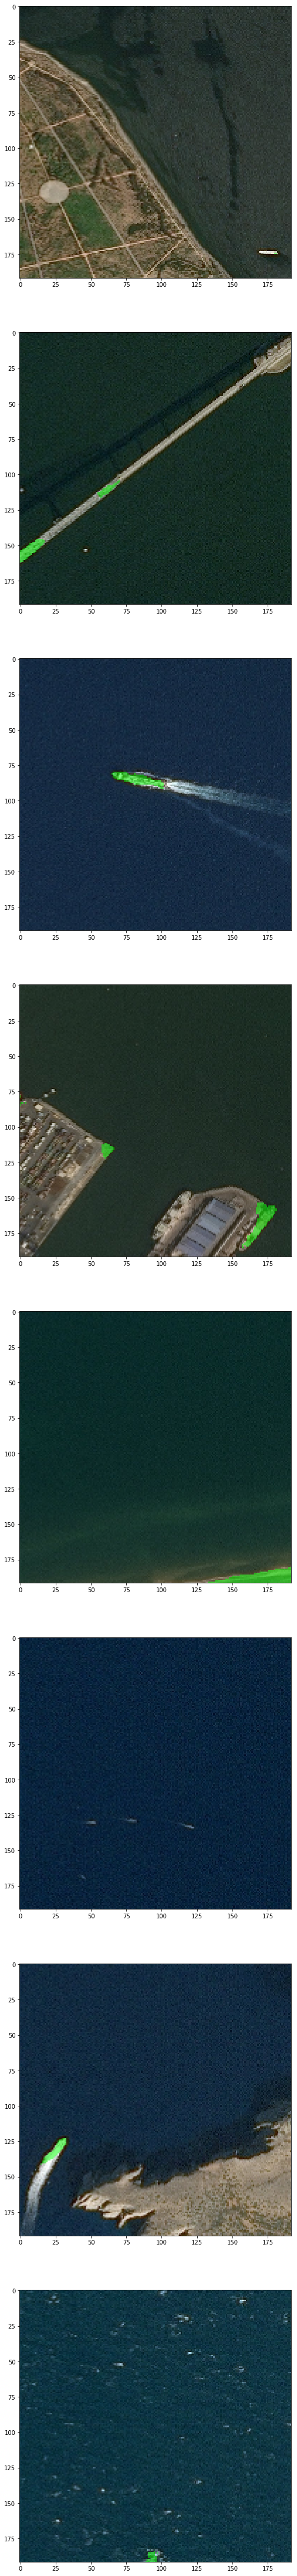

In [51]:
fig = plt.figure(figsize=(10, 80))

for i, img in enumerate(filenames):
    img_file_name = '/home/raznem/proj_kaggle_airbus/data/test_v2/{}.jpg'.format(img)

    image = load_image(img_file_name)

    with torch.no_grad():
        input_image = torch.unsqueeze(img_to_tensor(img_transform(p=1)(image=image)['image']).cuda(), dim=0)

    mask = model(input_image)
    mask_array = mask.data[0].cpu().numpy()[0] > 0
    
    fig.add_subplot(8, 1, i+1)
    imshow(mask_overlay(image[::4, ::4], mask_array[::4, ::4]))
    
plt.show()